# Halo-galaxy connection

### Authors: [Natalí S. M. de Santi](https://natalidesanti.github.io/) and [Christopher Lovell](https://www.christopherlovell.co.uk/)

In this tutorial we are going to see some ideas about how to work with **halo-galaxy connection** in the context of **machine learning** techniques.

## Summary

* 0. Handling data
* 1. Neural Networks

## Running options

* **On the fly:** you can easily work with this complete notebook in `google colab`: 

[![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/natalidesanti/galevo23-tutorials/blob/tutorial_on_halo-galaxy_connection/week-2/tutorial_on_halo-galaxy_connection/halo-galaxy_connection.ipynb)

* **Own computer:** otherwise you can download the notebook in your own computer and work with it in your own space. Just take care with the library dependencies. 

This current notebook contains the complete tutorial.

## 0. Handling data

We are going to see how to read IllustrisTNG data and the
main aspects that we are going to use from this, as a dataset, for the machine
learning session.

We are going to work with **IllustrisTNG** halo/galaxy catalog, from [**CAMELS**](https://camels.readthedocs.io/en/latest/). 
A complete description of the data, as well other user instructions, is given in the [webpage](https://camels.readthedocs.io/en/latest/subfind.html).

### 0.0. Necessary libraries

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#Just in case, to not overload the notebook
warnings.filterwarnings("ignore")

### 0.1. Getting and reading the data

We will download the catalog from a specif link using `wget`

In [2]:
!wget -q -nc -O fof_subhalo_tab_033.hdf5 https://www.dropbox.com/s/fgkxv5w8qr9v54m/fof_subhalo_tab_033.hdf5?dl=0

The **IllustrisTNG** data is a `.hdf5` file. We can read their content using the library `h5py`, using the `keys` method:

In [3]:
f = h5py.File('fof_subhalo_tab_033.hdf5')
f.keys()

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

The catalog specs are given by:

In [4]:
BoxSize      = f['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = f['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = f['Header'].attrs[u'Time']           #scale factor
h            = f['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
Omega_m      = f['Header'].attrs[u'Omega0']         #Omega_matter
Omega_L      = f['Header'].attrs[u'OmegaLambda']    #Omega_baryon

In [5]:
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift)
print('Omega_m:                  %.3f'%Omega_m)
print('Omega_L:                  %.3f'%Omega_L)

Box size:                 25.00 Mpc/h
snapshot redshift:        0.00
Omega_m:                  0.300
Omega_L:                  0.700


Apart from the specifications, the catalogs contain two main groups:

* **Group:** contains the properties of the halos.

* **Subhalos:** contains the properties of the subhalos. Galaxies, are considered as subhalos with stellar mass larger than 0.

In this tutorial we are going to work with both (halos and galaxies). So, le't get some of their properties.

### 0.2. Getting halo and galaxy properties

In [6]:
c = 3.*10**8

# Positions, velocities and masses of the halos
M_h =   f['Group/Group_M_Crit200'][:]*1e10      #Msun/h
R_h =   f['Group/Group_R_Crit200'][:]/c         #kpc/h
V_h  =  f['Group/GroupVel'][:]                  #km/s
V_h =   np.linalg.norm(V_h, axis = 1)
ID_r =  f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
ID_h =  np.arange(0, M_h.shape[0], 1, dtype = float) #It is the ID of the halos, to match the gal cat

# Positions, stellar masses,  of the galaxies
M_g    = f['Subhalo/SubhaloMassType'][:,4]*1e10 #Msun/h
color_g = f['Subhalo/SubhaloStellarPhotometrics'][:]
color_g = color_g[:, 4] - color_g[:, 6]
SFR = f['Subhalo/SubhaloSFR'][:]*1e10 #(Msun/year)/ (10^10 Msun/h)
ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs

# close file
f.close()

You can see that the number of halos is not the same as the number of galaxies, because we have halos without and with more than one galaxy (central and satellites):

In [7]:
M_h.shape, M_g.shape

((20131,), (17176,))

Taking only the halos which have galaxies

In [8]:
indexes = np.where( ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

ID_h.shape

(13837,)

Creating the halo and galaxy catalogs

In [9]:
# Halo catalog
data = np.array( [ M_h, R_h, V_h, ID_h ] ).T
columns = [ 'M_h', 'R_h', 'V_h', 'ID' ] 
halos = pd.DataFrame(data = data, columns = columns)
halos.head(3)

,M_h,R_h,V_h,ID
0,4.500575e+13,0.000002,27.004244,0.0
1,1.912689e+13,0.000001,56.368275,1.0
2,2.011009e+13,0.000001,188.867279,2.0


In [10]:
#Galaxy catalog
data = np.array( [ M_g, color_g, SFR, ID_g ] ).T
columns = [ 'M_g', 'color_g', 'SFR_g', 'ID' ] 
gals = pd.DataFrame(data = data, columns = columns)
gals.head(3)

,M_g,color_g,SFR_g,ID
0,4.267894e+11,1.126476,0.000000e+00,0.0
1,2.398532e+10,0.826265,1.699688e+10,0.0
2,1.551164e+10,0.798616,2.204744e+09,0.0


Keeping only central galaxies

In [11]:
gals = gals.drop_duplicates(subset = ['ID'], keep = 'first')

Matching the halo to the galaxy catalogs

In [12]:
df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on = 'ID')
df.shape

(13837, 7)

Cleaning the data

In [13]:
df = df[ df['M_g'] > 0 ] #Considering only galaxies [gals are gals if SM > 0]

In [14]:
#Converting SFR from the non-forming galaxies to have a SFR equal to a Gaussian distribution
df['SFR_g'] = df['SFR_g'].replace(0, 1)
df['SFR_g'] = np.log10(df['SFR_g'])
df.loc[df['SFR_g'] == 0, "SFR_g"] = np.random.normal(7, 0.5, len(df.loc[df["SFR_g"] == 0]))

In [15]:
#Just dropping the ID column because we don't need it anymore
df = df.drop(['ID'], axis = 1)
df.shape

(1514, 6)

Now, let's see some statiscs from these halos/galaxies:

In [16]:
df.describe()

,M_h,R_h,V_h,M_g,color_g,SFR_g
count,1.514000e+03,1.514000e+03,1514.000000,1.514000e+03,1514.000000,1514.000000
mean,2.590867e+11,2.269759e-07,159.914377,3.018712e+09,0.678903,7.639860
std,1.656051e+12,1.490707e-07,84.731841,1.944717e+10,0.192099,1.044259
min,1.443876e+09,6.127277e-08,7.104222,1.739187e+06,-0.794176,5.191712
25%,2.201826e+10,1.519423e-07,100.411592,1.297332e+07,0.638956,6.897166
50%,4.039674e+10,1.860214e-07,144.193092,3.437585e+07,0.700603,7.363575
75%,9.681791e+10,2.489396e-07,204.188789,2.047698e+08,0.764560,8.284218
max,4.500575e+13,1.928402e-06,563.310913,4.267894e+11,1.197241,10.718828


### 0.3. Data-preprocessing

It is important to deal with data in small range, usually, around 1 and 0. So, let's take the $log_{10}$ of the properties

In [17]:
df['M_h'] = np.log10(df['M_h'])
df['R_h'] = np.log10(df['R_h'])
df['V_h'] = np.log10(df['V_h'])
df['M_g'] = np.log10(df['M_g'])

Text(0.5, 0, 'V_h')

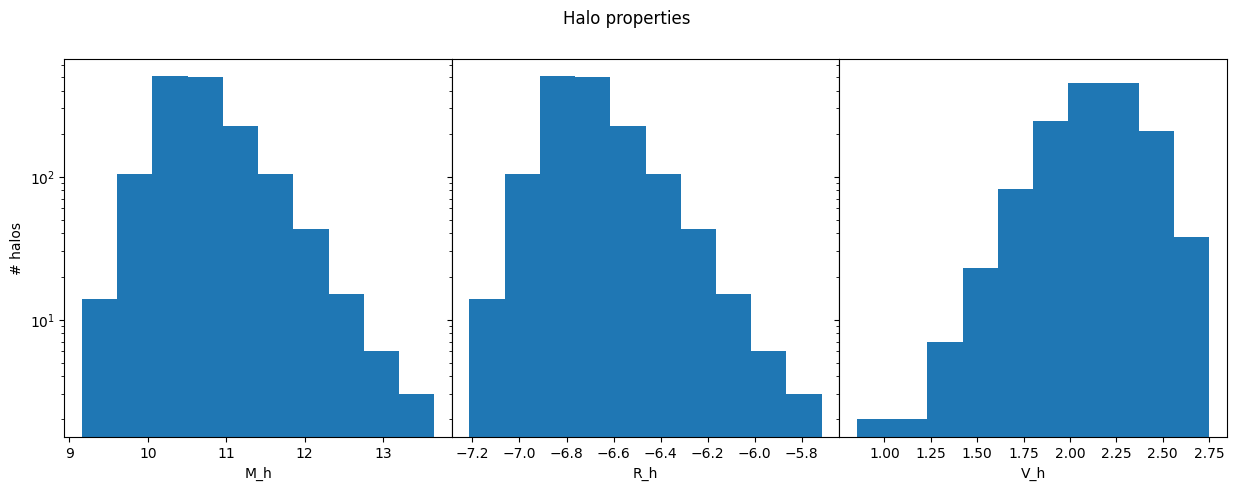

In [18]:
fig = plt.figure(dpi = 100, figsize = (15, 5))
gs = fig.add_gridspec(1, 3, hspace = 0, wspace = 0)
axs = gs.subplots(sharey = True)

fig.suptitle('Halo properties')

axs[0].hist(df['M_h'])
axs[0].set_yscale('log')
axs[0].set_xlabel('M_h')
axs[0].set_ylabel('# halos')

axs[1].hist(df['R_h'])
axs[1].set_yscale('log')
axs[1].set_xlabel('R_h')

axs[2].hist(df['V_h'])
axs[2].set_yscale('log')
axs[2].set_xlabel('V_h')

Text(0.5, 0, 'SFR')

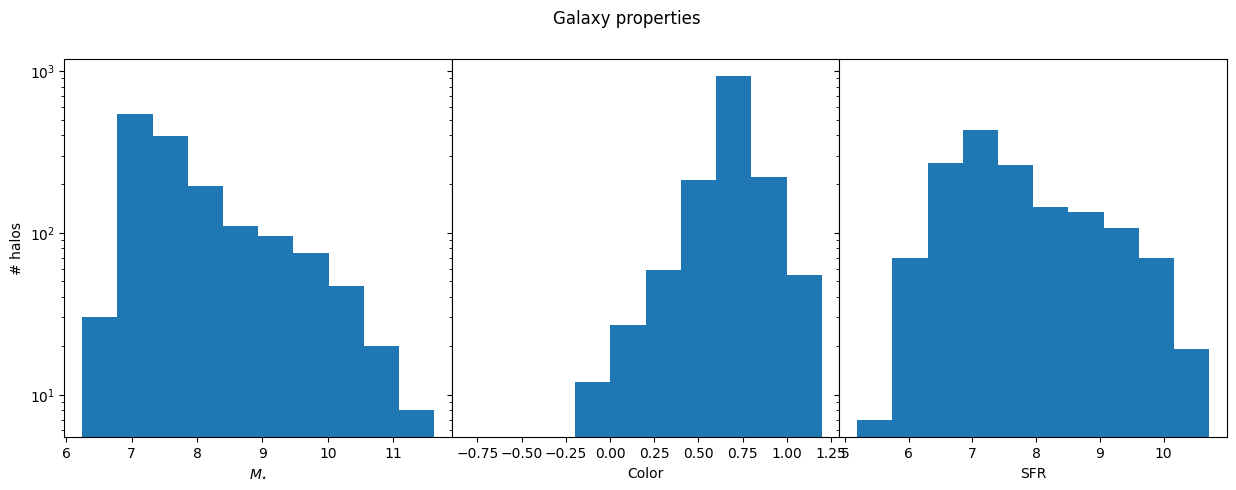

In [19]:
fig = plt.figure(dpi = 100, figsize = (15, 5))
gs = fig.add_gridspec(1, 3, hspace = 0, wspace = 0)
axs = gs.subplots(sharey = True)

fig.suptitle('Galaxy properties')

axs[0].hist(df['M_g'])
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$M_{\star}$')
axs[0].set_ylabel('# halos')

axs[1].hist(df['color_g'])
axs[1].set_yscale('log')
axs[1].set_xlabel('Color')

axs[2].hist(df['SFR_g'])
axs[2].set_yscale('log')
axs[2].set_xlabel('SFR')

### 0.4. Measuring the correlation among halo/galaxy properties

Here we are going to measure the [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
\begin{equation}
 PCC = \frac{ \mathrm{cov} (X, Y) }{ \sigma_X \sigma_Y }
\end{equation}

and plotting it as a heatmap of the values.

In [20]:
def correlation_heatmap(df):
    correlations = df.corr(method = 'pearson')

    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.2f',
                square = True, linewidths = .5, annot = True, 
                cbar_kws = {"shrink": .82})
    plt.title('Pearson correlation Heatmap')
    plt.show()
    
    return correlations

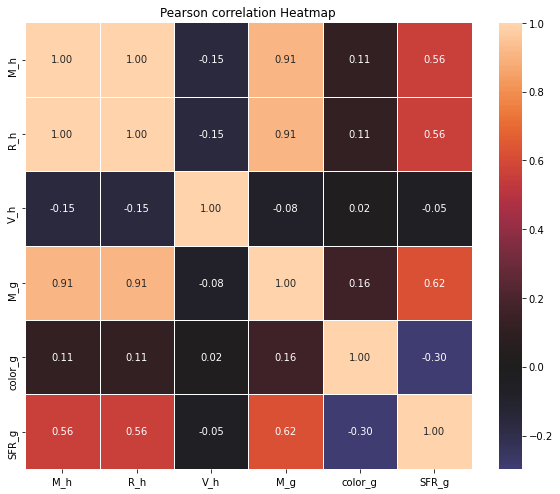

,M_h,R_h,V_h,M_g,color_g,SFR_g
M_h,1.000000,1.000000,-0.154836,0.910068,0.113225,0.557368
R_h,1.000000,1.000000,-0.154837,0.910068,0.113225,0.557367
V_h,-0.154836,-0.154837,1.000000,-0.082602,0.017113,-0.051564
M_g,0.910068,0.910068,-0.082602,1.000000,0.162549,0.620962
color_g,0.113225,0.113225,0.017113,0.162549,1.000000,-0.296160
SFR_g,0.557368,0.557367,-0.051564,0.620962,-0.296160,1.000000


In [21]:
correlation_heatmap(df)

### 0.5. Saving the dataset

In [22]:
#To save in the main directory - COLAB
df.to_csv('halos_and_gals.csv', index = False)

Saving as train and test sets

In [23]:
#Randomizing
df = df.sample(frac = 1, random_state = 42)

In [24]:
#Train and test
total = df.shape[0]
frac = 0.8

df_train = df.iloc[:int(frac*total), :] #train
df_test = df.iloc[int(frac*total):, :] #test

In [25]:
#To save in the main directory - COLAB
df_train.to_csv('train-halos_and_gals.csv', index = False)
df_test.to_csv('test-halos_and_gals.csv', index = False)

## 1. Neural Networks

Now we are going to see how to build a **Neural Network** to predict some galaxy properties, based in some halo properties.

### 1.0. Necessary libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import seaborn as sns
from keras import models
from keras import layers
from keras import regularizers
import os
from scipy.stats import gaussian_kde
from numpy.random import seed
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import set_random_seed
from numpy.random import seed
from tensorflow.keras.models import load_model

### 1.1. Reading the data

We are going to work to the data created above

In [27]:
df_train = pd.read_csv('train-halos_and_gals.csv')
df_test = pd.read_csv('test-halos_and_gals.csv')

If, for some reason, you had problems to generate the data you can download it using the following piece of code (you need to remove it from commentary)

In [28]:
# # Downloading it from the cloud
# !wget -q -nc -O test-halos_and_gals.csv https://www.dropbox.com/s/y9rsx6gtjsdr7r1/test-halos_and_gals.csv?dl=0
# !wget -q -nc -O train-halos_and_gals.csv https://www.dropbox.com/s/gncweskcappi81t/train-halos_and_gals.csv?dl=0

# df_train = pd.read_csv('train-halos_and_gals.csv')
# df_test = pd.read_csv('test-halos_and_gals.csv')

Using:
* halos: mass, radius, velocity modulus

To predict
* galaxies: stellar masses

\begin{equation}
 \{ M_h, R_h, V_h \} \Rightarrow M_{\star}
\end{equation}

In [29]:
x_train = np.array([df_train['M_h'], df_train['R_h'], df_train['V_h']]).T
x_test = np.array([df_test['M_h'], df_test['R_h'], df_test['V_h']]).T

y_train = np.array([df_train['M_g']]).T
y_test = np.array([df_test['M_g']]).T

In [30]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1211, 3), (303, 3), (1211, 1), (303, 1))

### 1.2. Pre-processing the data

We will do the following transformation
\begin{equation}
 data \Rightarrow \frac{(data - mean)}{std}
\end{equation}

In [31]:
#Taking mean and std
mean_data = np.mean(x_train, axis = 0)
std_data = np.std(x_train, axis = 0)
mean_data, std_data

(array([10.72031404, -6.69246455,  2.14441201]),
 array([0.57831041, 0.19277028, 0.24073891]))

In [32]:
x_train -= mean_data
x_train /= std_data
x_test -= mean_data
x_test /= std_data

### 1.3. Neural Networks

A **neural network** is a collection of _nodes_ (neurons) that are arranged in a series of **layers**:

![](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg)

Each connection is responsible to give a weight: $\omega_i a_i$ and each layer is a summarization of them, plus a bias $b$, according too:
\begin{equation}
 b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} .
\end{equation}
Besides, we have another numeric transformation called **activation function**, responsible to perform a non linear transformation of the values of each layer
\begin{equation}
 y_{\mu} = f \left( b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} \right) ,
\end{equation}
that can assume different forms:

![](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

During the **training process** these _weights_ are adjusted through **epochs** in order to minimize the difference between the network predictions $y_{pred}$, and the target values $y_{target}$ through the minimization of a **loss function** (that also can assume different forms). In this tutorial we are going to use the **Mean Squared Error** (**MSE**)
\begin{equation}
 MSE = \frac{1}{m} \sum_{i = 1}^m (y_{pred} - y_{target})^2 ,
\end{equation}

### 1.3.1. Defining the model

First, defining the **random seed** to get reproducible results

In [33]:
set_random_seed(42)
seed(42)

Let's define a simple standard model according too:

In [34]:
def base_model():
    model = models.Sequential() 
    model.add(layers.Dense(16, activation = 'relu', 
                           input_shape = (x_train.shape[1],)))
    model.add(layers.Dense(8, activation = 'relu'))
    model.add(layers.Dense(1))
    
    print(model.summary())
    
    model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

Here you can visualize the model and their details

In [35]:
my_model = KerasRegressor(build_fn = base_model)
my_model

### 1.3.2. Fitting the model

The learning process is made by the `fit` function

In [36]:
#Fitting data
no_epochs = 100
batch_size = 50
validation_split = 0.2
history = my_model.fit(x_train, y_train, epochs = no_epochs, 
                       batch_size = batch_size, 
                       validation_split = validation_split, verbose = False)
history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________
None


To see if we don't have over/under fitting we can analyse the validation and training losses

In [37]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Text(0.5, 0, 'Epochs')

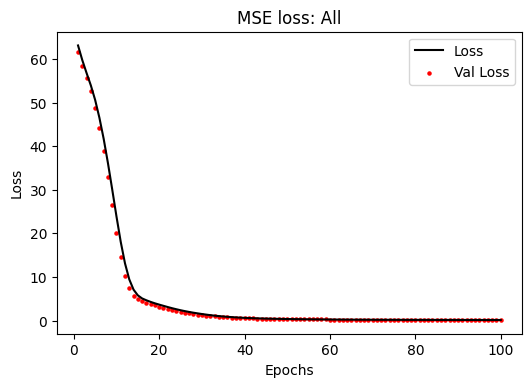

In [38]:
plt.figure(dpi=100)
plt.plot(epochs, train_loss, color = 'black',label = 'Loss')
plt.scatter(epochs, train_val_loss, s = 5, color = 'red', label = 'Val Loss')
plt.legend()  
plt.title('MSE loss: All')
plt.ylabel('Loss')
plt.xlabel('Epochs')

### 1.3.4. Saving the mode weights

We can save the model weights, to use later, to do the predictions, according to:

In [39]:
my_model.model.save('model.h5')

### 1.3.3. Doing the predictions

The predictions are done using the `predict` function, after loading the saved model:

In [40]:
#Loading the model
loaded_model = load_model('model.h5')

In [41]:
#Predictions
prediction_1 = loaded_model.predict(x_test)

10/10 [==============================] - 0s 1ms/step


### 1.3.4. Performance

#### a) We check the final performance taking a look of some metric computed over the predictions

In [42]:
#Scores
MSE_1 = mean_squared_error(prediction_1, y_test)
MSE_1

0.1038246163867994

#### b) Visualizing the results

Scatter plot

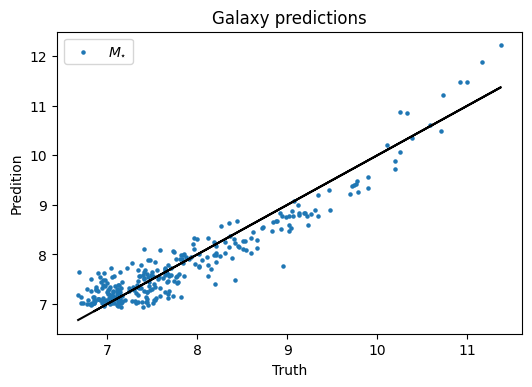

In [43]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')
plt.scatter(y_test, prediction_1, s = 5, color = 'C0', label = '$M_{\star}$')
plt.xlabel(r'Truth')
plt.plot(y_test, y_test, color = 'black')
plt.ylabel(r'Predition')
plt.legend()

Histogram

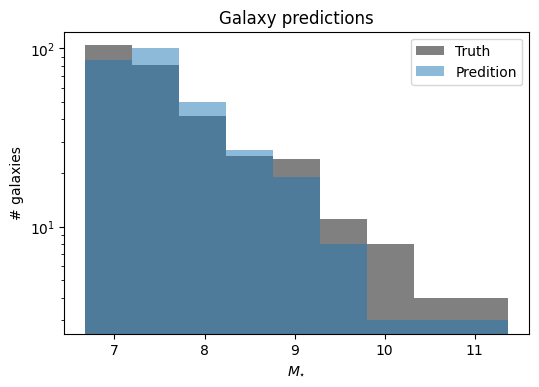

In [44]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')

bins = np.linspace(np.min(y_test), np.max(y_test), 10)
plt.hist(y_test, bins = bins, color = 'gray', label = 'Truth')
plt.hist(prediction_1, bins = bins, color = 'C0', alpha = 0.5, label = 'Predition')
plt.xlabel(r'$M_{\star}$')
plt.ylabel(r'# galaxies')
plt.legend()
plt.yscale('log')

Let's try to do better, but first:

## 1.4. YOUR TURN

Try to create a NN to:

Using:
* halos: mass, radius, velocity modulus

To predict
* 1) galaxies: SFR
* 2) galaxies: color
* 3) galaxies: stellar mass, SFR, color

Try to think in which lines of code you need to change!
Are just the lines corresponding to the predictions?
Are there any issues related to dimensions then?

## 2. Optimizing the code

We can obtain better results doing a **hyperparameter optimization** and we can do this using `optuna`, a framework for automating the optimization process of these hyperparameters.

The main idea is to use a metric, from your validation set, to look for the best set of hyperparameters:

![](https://editor.analyticsvidhya.com/uploads/67819opt.png)

Let's do it!

### 2.0. Necessary libraries

In [45]:
import optuna

### 2.1. The objective function

We start defining an **objective function**, the function which will be optimized.

**First**, we need to define some hyperparameters to be tunned. For simplycity le't choose:

* Number of middle layer
* Number of hidden neurons per layer

Then, we need to define their range.

**Second**, we write our model.

**Third**, we have to fit the model.

**Fourth**, we need to write the quantity to be optmized and how. We are going to chose the model which minimized the MSE for the validation set!

In [46]:
def objective(trial):
    
    #Defining the hyperparameters and their ranges
    n_layers = trial.suggest_int('n_layers', 0, 5)
    hiddens = trial.suggest_int('hiddens', 0, 64)
    
    #The model
    def base_model():
        model = models.Sequential() 
        model.add(layers.Dense(hiddens, activation = 'relu', input_shape = (x_train.shape[1],)))
        for i in range(n_layers):
            model.add(layers.Dense(hiddens, activation = 'relu'))
        model.add(layers.Dense(1))
        
        model.compile(optimizer = 'Adam', loss = 'mse')
    
        return model
    
    my_model = KerasRegressor(build_fn = base_model)
    
    #Fitting the model
    no_epochs = 20
    batch_size = 20
    validation_split = 0.2
    history = my_model.fit(x_train, y_train, epochs = no_epochs, batch_size = batch_size, 
                 validation_split = validation_split, verbose = False)

    #Validation criteria to optmize
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    validation = 10000.
    
    for i in range(no_epochs):
        if val_loss[i] < train_loss[i]:
            validation = val_loss[i]
            
            my_model.model.save(f'trial{trial.number}-optuna_model.h5')
        
    return validation

### 2.2. Evaluation

The objective function value is evaluated using a study object which uses:

* **Direction:** which minimized in regression problems
* **Trials:** which is the number of runs to optuna find the best model

In [47]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 3)

[I 2023-01-19 17:35:34,147] A new study created in memory with name: no-name-f688306c-c8e1-4d2b-bfe3-d1b8175a336a
[I 2023-01-19 17:35:37,483] Trial 0 finished with value: 0.1802224963903427 and parameters: {'n_layers': 4, 'hiddens': 25}. Best is trial 0 with value: 0.1802224963903427.
[I 2023-01-19 17:35:40,126] Trial 1 finished with value: 0.29782965779304504 and parameters: {'n_layers': 0, 'hiddens': 64}. Best is trial 0 with value: 0.1802224963903427.
[I 2023-01-19 17:35:43,509] Trial 2 finished with value: 0.10924381762742996 and parameters: {'n_layers': 4, 'hiddens': 29}. Best is trial 2 with value: 0.10924381762742996.


Best model:

In [48]:
best_trial = study.best_trial
print("Best trial: ", best_trial.number)
print("Best hyperparameters: {}".format(best_trial.params))

Best trial:  2
Best hyperparameters: {'n_layers': 4, 'hiddens': 29}


### 2.3. Predictions

Doing the predictions using the best saved model:

In [49]:
#Loading the model
loaded_model = load_model(f'trial{best_trial.number}-optuna_model.h5')

In [50]:
#Predictions
prediction_2 = loaded_model.predict(x_test)

10/10 [==============================] - 0s 1ms/step


### 2.4. Performance

#### a) We check the final performance taking a look of some metric computed over the predictions

In [51]:
#Scores
MSE_2 = mean_squared_error(prediction_2, y_test)
MSE_2

0.08365326283927596

#### b) Visualizing the results

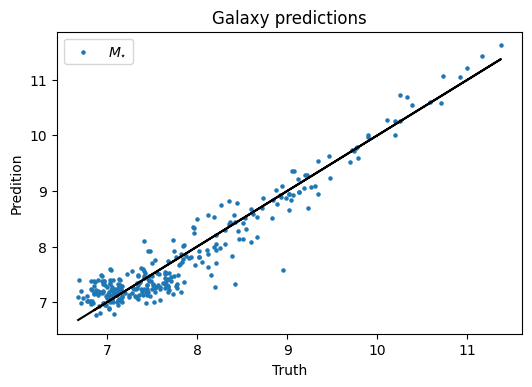

In [52]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')
plt.scatter(y_test, prediction_2, s = 5, color = 'C0', label = '$M_{\star}$')
plt.xlabel(r'Truth')
plt.plot(y_test, y_test, color = 'black')
plt.ylabel(r'Predition')
plt.legend()

Histogram

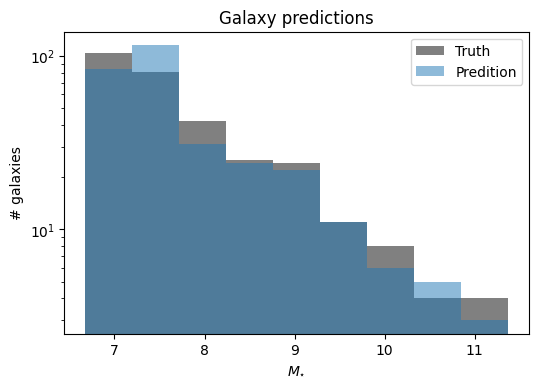

In [53]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')

bins = np.linspace(np.min(y_test), np.max(y_test), 10)
plt.hist(y_test, bins = bins, color = 'gray', label = 'Truth')
plt.hist(prediction_2, bins = bins, color = 'C0', alpha = 0.5, label = 'Predition')
plt.xlabel(r'$M_{\star}$')
plt.ylabel(r'# galaxies')
plt.legend()
plt.yscale('log')

### 2.5. YOUR TURN

Try to create a optuna optimization to:

Using:
* halos: mass, radius, velocity modulus

To predict
* 1) galaxies: SFR
* 2) galaxies: color
* 3) galaxies: stellar mass, SFR, color

## 3. The imbalanced problem

In ML, there is a common problem with so-called **imbalanced data sets**. 
In these samples, relatively underrepresented regions of the data space may carry the same, or even higher importance, 
than the bulk of the distribution. 
These data are harder to predict by the machine which focuses on learning about the regions around the peak of the
distribution in the parameter space.

We can apply:
* **Over-sampling:** increasing the amoun of data
* **Under-sampling:** reducing the amount of data 
in conveniently chosen regions of the distribution.

Here we are going to use **Synthetic Minority Over-Sampling Technique for Regression with Gaussian Nois ([SMOGN](https://pypi.org/project/smogn/))**.
It works by combining random **under-sampling** with **two over-sampling techniques**: SmoteR and Gaussian noise.
The algorithm first bins the data for a given target variable and subsequently splits the resulting distribution in **rare** and
**normal** bins. Rare bins are augmented, whereas normal bins are under-sampled.

![](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZYAAAD8CAYAAABU4IIeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nO3deXxU1f34/9d7JplsZIEkQCBgIosQ%0AZFEQVJAqVFzagmuFfqzaWm2rftRqrfjRVlur39qPv6ptpdZWW21VRKuVj2tV3BdW2dewhzX7vs6c%0A3x/3DgxhkkxmJpOZ5P18PPKYyZlz3+fMJPDOuefcc8UYg1JKKRUuju7ugFJKqZ5FE4tSSqmw0sSi%0AlFIqrDSxKKWUCitNLEoppcJKE4tSSqmwCiixiMj5IrJFRApFZL6f1xNE5EX79aUikufz2l12+RYR%0AOa+jmCKSb8cotGO67PLpIrJKRFpE5DKf+hNE5AsR2SAia0XkiuA+CqWUUuHQYWIRESfwOHABUADM%0AE5GCVtWuBcqNMcOBR4CH7GMLgLnAGOB8YIGIODuI+RDwiB2r3I4NsAe4Bni+Vdt1wFXGGG8bj4pI%0ARmBvXymlVLgFMmKZDBQaY3YYY5qAhcCcVnXmAM/Yz18GZoqI2OULjTGNxpidQKEdz29M+5gZdgzs%0AmBcBGGN2GWPWAh7fho0xW40x2+zn+4HDQHbAn4BSSqmwigugzmBgr8/3RcCUtuoYY1pEpBLItMu/%0AbHXsYPu5v5iZQIUxpsVP/Q6JyGTABWxvr15WVpbJy8sLNKxSSilg5cqVJcaYDv9wDySxxAQRyQH+%0AAVxtjPH4ef164HqAoUOHsmLFigj3UCmlYpuI7A6kXiCnwvYBQ3y+z7XL/NYRkTggHSht59i2ykuB%0ADDtGW20dR0TSgDeAu40xX/qrY4x50hgzyRgzKTtbz5QppVRXCSSxLAdG2Ku1XFiT8Ytb1VkMXG0/%0AvwxYYqzdLRcDc+1VY/nACGBZWzHtYz6wY2DHfK29ztnHvwo8a4x5ub26Simlul6HicWe77gJeAfY%0ABCwyxmwQkV+JyGy72lNApogUArcB8+1jNwCLgI3A28CNxhh3WzHtWHcCt9mxMu3YiMhpIlIEXA78%0AWUS89b8NTAeuEZHV9teEED4TpZRSIZDeuG3+pEmTjM6xKNXzNTc3U1RURENDQ3d3JaYkJiaSm5tL%0AfHz8MeUistIYM6mj43vM5L1SSrVWVFREamoqeXl5WFczqI4YYygtLaWoqIj8/PygYuiWLkqpHquh%0AoYHMzExNKp0gImRmZoY0ytPEopTq0TSpdF6on5kmFqWU6mJFRUXMmTOHESNGMGzYMG655RaampqO%0Aq7d//34uu+wyPxGOdeGFF1JRURFUX+677z4efvjhoI4NlCaWnmLL2/DwSVBX1t09UUr5MMZwySWX%0AcNFFF7Ft2za2bt1KTU0Nd9999zH1WlpaGDRoEC+/3PFVE2+++SYZGdG7JaImlp5i69tQc9B6VEpF%0AjSVLlpCYmMj3vvc9AJxOJ4888ghPP/00CxYsYPbs2cyYMYOZM2eya9cuTj75ZADq6ur49re/TUFB%0AARdffDFTpkw5smNIXl4eJSUl7Nq1i9GjR3PdddcxZswYZs2aRX19PQB/+ctfOO200xg/fjyXXnop%0AdXV1EXvPmlh6in0rrcfNb3RvP5RSx9iwYQMTJ048piwtLY2hQ4fS0tLCqlWrePnll/noo4+OqbNg%0AwQL69u3Lxo0buf/++1m5cqXf+Nu2bePGG29kw4YNZGRk8K9//QuASy65hOXLl7NmzRpGjx7NU089%0A1TVv0A9dbtwTNNfDoQ3giIfC96GpDlzJ3d0rpaLKL/9vAxv3V4U1ZsGgNO791piQYpx77rn069fv%0AuPJPP/2UW265BYCTTz6ZcePG+T0+Pz+fCROsa8InTpzIrl27AFi/fj333HMPFRUV1NTUcN555/k9%0AvivoiKUnOLAWjBsmfR9a6mHHh93dI6WUraCg4LjRRlVVFXv27CEuLo6UlJSQ4ickJBx57nQ6aWmx%0ANoe/5ppr+OMf/8i6deu49957I3qRqI5YegLvabCpN8OahdbpsFEXdm+flIoyoY4sgjVz5kzmz5/P%0As88+y1VXXYXb7eb222/nmmuuITm57TMLU6dOZdGiRZxzzjls3LiRdevWdard6upqcnJyaG5u5rnn%0AnmPw4IDvQBIyHbH0BPtWQFoupOfCyFmw5U1wt3R8nFKqy4kIr776Ki+99BIjRoxg5MiRJCYm8uCD%0AD7Z73A033EBxcTEFBQXcc889jBkzhvT09IDbvf/++5kyZQpTp05l1KhRob6NTtG9wnqCx8bDwHFw%0AxT9gw6vw0jVwzZuQN7W7e6ZUt9q0aROjR4/u7m4Exe1209zcTGJiItu3b+frX/86W7ZsweVyRaR9%0Af5+d7hXWW9SWQvkua34FYPjXrcfdn2liUSqG1dXVcc4559Dc3IwxhgULFkQsqYRKE0us27/Kehxs%0AL2dMSIXkLKja3319UkqFLDU1NWbvdKtzLLFu30oQB+T43IImNQeqD3Rfn5RSvZomlli3byVkj4KE%0APkfL0jSxKKW6jyaWWFe2E7JGHluWOhCqD3ZPf5RSvZ4mllhXWwx9+h9blpoDNYd1ybFSqltoYoll%0ALU3QUAEp2ceWpw4EDNQc6pZuKaWOEhGuvPLKI9+3tLSQnZ3NN7/5zU7F8W48CXDmmWceKb/jjjsY%0AM2YMd9xxB0888QTPPvtsp+L26dOn40qdpKvCYlmd9Ut2fGIZZD1WH4T0yF1tq5Q6XkpKCuvXr6e+%0Avp6kpCTefffdkK+C//zzz488f/LJJykrK8PpdIba1bDREUssqzlsPfodsaAT+EpFiQsvvJA33rB2%0AHn/hhReYN2/ekdfKysq46KKLGDduHKeffjpr164FoLS0lFmzZjFmzBh+8IMf4Hsxu3eUMXv2bGpq%0Aapg4cSIvvvjiMTfx2r59O+effz4TJ07krLPOYvPmzQDs3LmTM844g7Fjx3LPPfd0yfvVxBLLau0R%0Ai785FtDEolSUmDt3LgsXLqShoYG1a9cyZcqUI6/de++9nHLKKaxdu5YHH3yQq666CoBf/vKXTJs2%0AjQ0bNnDxxRezZ8+e4+IuXryYpKQkVq9ezRVXXHHMa9dffz1/+MMfWLlyJQ8//DA33HADALfccgs/%0A/vGPWbduHTk5OV3yfvVUWCyr9Y5Yso4tT8kGcWpiUcrXW/PhYOc2cuzQwLFwwW86rDZu3Dh27drF%0ACy+8wIUXHrtB7KeffnrkHiozZsygtLSUqqoqPv74Y1555RUAvvGNb9C3b9+Au1VTU8Pnn3/O5Zdf%0AfqSssbERgM8+++xIe9/97ne58847A44bKE0ssay22HpMaTVicTh0ybFSUWb27Nn89Kc/5cMPP6S0%0AtLRL2/J4PGRkZLB69Wq/r4tIl7aviSWW1RyGuCRw+bmfQ+pAHbEo5SuAkUVX+v73v09GRgZjx47l%0Aww8/PFJ+1lln8dxzz/Hzn/+cDz/8kKysLNLS0pg+fTrPP/8899xzD2+99Rbl5eUBt5WWlkZ+fj4v%0AvfQSl19+OcYY1q5dy/jx45k6dSoLFy7kyiuv5LnnnuuCd6pzLLGttgT6ZIO/vz5Sc3TEolQUyc3N%0A5eabbz6u/L777mPlypWMGzeO+fPn88wzzwDW3MvHH3/MmDFjeOWVVxg6dGin2nvuued46qmnGD9+%0APGPGjOG1114D4LHHHuPxxx9n7Nix7Nu3L/Q35odumx/L/nExNFTCdUuOf+2Nn8K6l2D+7sj3S6ko%0AEcvb5ne3ULbND2jEIiLni8gWESkUkfl+Xk8QkRft15eKSJ7Pa3fZ5VtE5LyOYopIvh2j0I7pssun%0Ai8gqEWkRkctatX+1iGyzv64O5D31CLXFx8+veKUOtC6ebK6PbJ+UUr1eh4lFRJzA48AFQAEwT0QK%0AWlW7Fig3xgwHHgEeso8tAOYCY4DzgQUi4uwg5kPAI3ascjs2wB7gGuD5Vv3rB9wLTAEmA/eKSODL%0AJ2JZTfHxK8K8jiw51tNhSqnICmTEMhkoNMbsMMY0AQuBOa3qzAGesZ+/DMwUa9nBHGChMabRGLMT%0AKLTj+Y1pHzPDjoEd8yIAY8wuY8xawNOq7fOAd40xZcaYcuBdrCTWs3k81pX3ra9h8UrTxKKU6h6B%0AJJbBwF6f74vsMr91jDEtQCWQ2c6xbZVnAhV2jLbaCqZ/PU9DBXhajr/q3uvIiEVv+KV6t944jxyq%0AUD+zXrMqTESuF5EVIrKiuLi4u7sTuiPXsLSVWLzbuuiIRfVeiYmJlJaWanLpBGMMpaWlJCYmBh0j%0AkOtY9gFDfL7Ptcv81SkSkTggHSjt4Fh/5aVAhojE2aMWf23569/ZrWJ92LqSMeZJ4EmwVoV1EDP6%0AtbVPmFdiBsQl6rUsqlfLzc2lqKiIHvHHZAQlJiaSm5sb9PGBJJblwAgRycf6T3wu8J1WdRYDVwNf%0AAJcBS4wxRkQWA8+LyO+AQcAIYBkg/mLax3xgx1hox3ytg/69AzzoM2E/C7grgPcV2zoasYjotSyq%0A14uPjyc/P7+7u9HrdHgqzB453IT1H/gmYJExZoOI/EpEZtvVngIyRaQQuA2Ybx+7AVgEbATeBm40%0AxrjbimnHuhO4zY6VacdGRE4TkSLgcuDPIrLBbqMMuB8rAS4HfmWX9WzexNLW5D1YiaVKRyxKqcgK%0AaEsXY8ybwJutyn7h87wB6z98f8c+ADwQSEy7fAfWqrHW5cuxTnP5a+Np4Ol230RPU1sM4oCkdlZW%0Apw6EA2si1yellKIXTd73ODWHITkLHO3c3Ccl++jNwJRSKkI0scSq2pK251e8kjOtLV/czZHpk1JK%0AoYkldtUetjagbE9yP+uxPvBdUZVSKlSaWGJVbXFgIxaAuq6994NSSvnSxBKratrZgNJLE4tSqhto%0AYolFTbXQXNv2BpRe3tdrdQJfKRU5mlhiUSDXsICOWJRS3UITSyzyJgpv4mhLkj15X9fzrxdVSkUP%0ATSyxyLvKq72LIwHiXJCQpiMWpVREaWKJRfUV1mNHiQWsJceaWJRSEaSJJRZ5RyyJGR3XTc7Sq++V%0AUhGliSUWNXhHLIEklkwdsSilIkoTSyyqr4D4ZIhL6LhucqZO3iulIkoTSyyqrwhsfgV0jkUpFXGa%0AWGJRfXlg8ytgjVia66Cprmv7pJRSNk0ssaihIrD5FTh69b2OWpRSEaKJJRbVl3fiVJhefa+UiixN%0ALLGovqJzp8JAE4tSKmI0scSizpwKO5JYdGWYUioyNLHEmpZGazK+04lFL5JUSkWGJpZY05ntXMA6%0AZSYOPRWmlIoYTSyxpjPbuQA4HNYux5pYlFIRookl1jR0csQCuq2LUiqiNLHEmiNb5gc4YgErsdRq%0AYlFKRYYmlljT2TkW0G1dlFIRpYkl1nR2jgWsq+81sSilIkQTS6xpqAAEEtMDP8Y7x2JMl3VLKaW8%0AAkosInK+iGwRkUIRme/n9QQRedF+famI5Pm8dpddvkVEzusopojk2zEK7Ziu9toQkXgReUZE1onI%0AJhG5K9gPIybUl0NiGjicgR+TnAnGDQ2VXdcvpZSydZhYRMQJPA5cABQA80SkoFW1a4FyY8xw4BHg%0AIfvYAmAuMAY4H1ggIs4OYj4EPGLHKrdjt9kGcDmQYIwZC0wEfuib2HqczmyZ76XbuiilIiiQEctk%0AoNAYs8MY0wQsBOa0qjMHeMZ+/jIwU0TELl9ojGk0xuwECu14fmPax8ywY2DHvKiDNgyQIiJxQBLQ%0ABFQF/AnEms5sme+liUUpFUGBJJbBwF6f74vsMr91jDEtQCWQ2c6xbZVnAhV2jNZttdXGy0AtcADY%0AAzxsjOm5G2M16IhFKRXdesLk/WTADQwC8oHbReTE1pVE5HoRWSEiK4qLiyPdx/CpL+/cNSygiUUp%0AFVGBJJZ9wBCf73PtMr917FNS6UBpO8e2VV4KZNgxWrfVVhvfAd42xjQbYw4DnwGTWr8JY8yTxphJ%0AxphJ2dnZAbztKKVzLEqpKBdIYlkOjLBXa7mwJuMXt6qzGLjafn4ZsMQYY+zyufaKrnxgBLCsrZj2%0AMR/YMbBjvtZBG3uw5mUQkRTgdGBzoB9ATDEmuDkWVwo4E6BWdzhWSnW9uI4qGGNaROQm4B3ACTxt%0AjNkgIr8CVhhjFgNPAf8QkUKgDCtRYNdbBGwEWoAbjTFuAH8x7SbvBBaKyK+Br+zYtNUG1uqyv4nI%0ABkCAvxlj1gb/kUSxphpr2XBnT4WJ2Ney9NypJ6VU9OgwsQAYY94E3mxV9guf5w1Yy379HfsA8EAg%0AMe3yHVjzJq3L/bZhjKlpq+0e58g+YZ08FQaQohtRKqUioydM3vce3n3COnsqDHSHY6VUxGhiiSXB%0AbJnvlZypd5FUSkWEJpZYEsyW+V46YlFKRYgmllgSzJb5XsmZ1l5h7ubw9kkppVrRxBJLgtky38t7%0ALYs3hlJKdZGAVoWpKNFQAY5467qUzvK9SLJPf79VPt5azO6yOlxOYcygdE4e3Imt+ZVSyqaJJZZ4%0At3MR6fyx3sTSxkWSu0trueZvy/DYt2yJdwpv3zqdYdl9guysUqq30lNhsSSY7Vy8OtjW5YmPdhDn%0AdPDuT6bzn59MJzHeyX2LN2D05mBKqU7SxBJLgtnOxaudxHKwsoF/rSzi25NyGTEglZEDUrn93JF8%0Asq2Et9cfDKHDSqneSBNLLAlmy3yv5H7Wo59tXf76yQ7cxvDD6cOOlF15+gmMGpjK/a9vpK6p5bhj%0AlFKqLZpYYkkwW+Z7xSVAQtpxI5by2iaeW7qHOeMHMaRf8tHqTge/nD2G/ZUNvLh8b+toSinVJk0s%0AsaS+MvgRC1ijllZX37++dj/1zW6u/9pxt7BhyomZjM9NZ+GyvTrXopQKmCaWWOFxQ2Nl8HMs4Pfq%0A+y93lpGTnshJA1L9HjJv8lC2HKpm1Z6K4NtVSvUqmlhiRUOl9RjSiOXYxGKMYdnOMqbk90PaWML8%0ArfGDSHE5eWHZnuDbVUr1KppYYkUo+4R5tbony86SWoqrG5mcn9nmISkJccyeMJjX1+6nsl63g1FK%0AdUwTS6wIZZ8wr+TMYy6QXLrTSjJTTuzX7mHfmTyUhmYPi1e3viO1UkodTxNLrAhlnzCv5ExoqYem%0AOgCW7Swjq08CJ2a1v0XM2Nx0Th6cxnNL9+gkvlKqQ5pYYsWRe7GEmFgA6koxxrB0R2m78yu+5k0e%0AyuaD1awpqgy+faVUr6CJJVaEcltiL5/EUlRez/7KBibnt38azGv2+EEku5y8sFQn8ZVS7dPEEitC%0AuS2xl09iCXR+xSs1MZ5vjRvE/63dT3WDTuIrpdqmiSVWNFRAfArEuYKPkZJlPdaVsnRHKRnJ8Yzs%0A7//6FX/mTRlKXZObxWv2B98HpVSPp4klVoSynYuXz4hl9d4KTh3aF4cj8C34x+emMzonTa9pUUq1%0ASxNLrAhly3yvxHQQBy3VxewoqaUgJ61Th4sI35k8hPX7qvhqj96JUinlnyaWWBHKlvleDick9aWy%0A7BBuj2F0JxMLwMWn5pKaEMfTn+0KrS9KqR5LE0usaKgI/VQYQEp/6susOZJROYHPr3j1SYhj7uQh%0AvLnuAAcq60Pvj1Kqx9HEEivCMccCkDoQqT5AYryDvMz2L4xsy1Vn5GGM4dkvdofeH6VUj6OJJVaE%0AY44FIG0QSQ2HOWlgGs5OTNz7GtIvmfPGDOT5pXv0JmBKqeNoYokFzQ3WViyhzrEAJjWHdE8ZJw9M%0ACinO96flU1nfzCurdP8wpdSxAkosInK+iGwRkUIRme/n9QQRedF+famI5Pm8dpddvkVEzusopojk%0A2zEK7ZiuANoYJyJfiMgGEVknIonBfBhRqyEMG1DaquKzcGKY0De0ixwnndCXcbnp/O2znXg8un+Y%0AUuqoDhOLiDiBx4ELgAJgnogUtKp2LVBujBkOPAI8ZB9bAMwFxgDnAwtExNlBzIeAR+xY5Xbs9tqI%0AA/4J/MgYMwY4G+hZl4aHY8t82+7mdAAK+tSGFEdE+P7UfLYX1/LRtuKQ+6WU6jkCGbFMBgqNMTuM%0AMU3AQmBOqzpzgGfs5y8DM8Xa2XAOsNAY02iM2QkU2vH8xrSPmWHHwI55UQdtzALWGmPWABhjSo0x%0A7sA/ghgQji3zbZtrrZVg+YnVIce6cGwO/VMTePrTnSHHUkr1HIEklsHAXp/vi+wyv3WMMS1AJZDZ%0AzrFtlWcCFXaM1m211cZIwIjIOyKySkR+5u9NiMj1IrJCRFYUF8fYX9jh2DLf9lWFNbeS3HA45Fiu%0AOAdXnXECn2wrYeuh0BOVUqpn6AmT93HANOC/7MeLRWRm60rGmCeNMZOMMZOys7Mj3cfQhHGOZflh%0ABy04oSo8+319Z8oJJMQ5+NtnOmpRSlkCSSz7gCE+3+faZX7r2HMe6UBpO8e2VV4KZNgxWrfVVhtF%0AwMfGmBJjTB3wJnBqAO8rdoRpjqWh2c2O0nrqXFlQfSAMHYN+KS4uPmUwr361jyrd9VgpRWCJZTkw%0Awl6t5cKajF/cqs5i4Gr7+WXAEmPdanAxMNde0ZUPjACWtRXTPuYDOwZ2zNc6aOMdYKyIJNsJ52vA%0AxsA/ghhQXwEIJKSHFGbboRo8Btx9BoZtxAJwxWlDaGj28Mba8CQrpVRs6zCx2PMZN2H9B74JWGSM%0A2SAivxKR2Xa1p4BMESkEbgPm28duABZh/Uf/NnCjMcbdVkw71p3AbXasTDt2e22UA7/DSlargVXG%0AmDeC/UCiUn25tYGkI7Qzl955kPiMQWEbsQBMGJLB8P59eHllUdhiKqViV1zHVcAY8ybWKSbfsl/4%0APG8ALm/j2AeABwKJaZfvwFo11rq8vTb+ibXkuGcK0z5h2w7XEO8UkjKHQNGnYeiYRUS4fGIu/++t%0AzWwvrmFYdp+wxVZKxZ6eMHnf84VpO5dth6rJz0rBmT4ImqqhMXwruS4+dTBOh+ioRSmliSUmhGPL%0AfKwRy4gBqZA6yCqoPhhyTK/+qYmcPTKbV1YV4dYr8ZXq1TSxxIKG0Ecs9U1u9pbXWbciTsuxCsM4%0AgQ9w2cRcDlU18llhSVjjKqViiyaWWBCGLfMLD9dgDIwY0MdnxBLeVVznjOpPssvJOxvCNxJSSsUe%0ATSzRzuOxE0u/kMJsO2zNp4wc0KfLRiyJ8U6mj8jmvU2HsFaCK6V6I00s0a6+HIwHUkLbLWDrIWtF%0A2AmZKeBKsa6JCfOIBeDcggEcqmpk3b7KsMdWSsUGTSzRrs6er0jJCilM4WFrRVi80/6Rp+WEfcQC%0AMGNUfxwC7248FPbYSqnYoIkl2tXaG2YmZ4YUZushe0WYV2pOl4xY+qa4mJTXTxOLUr2YJpZoV+sd%0AsQR/Ksy7ImxEf58LF1NzoKprtmCZVTCAzQer2VtW1yXxlVLRTRNLtAvDqbDtxdaKsJG+I5a0HKg5%0ABO7w37P+3IIBgJ4OU6q30sQS7bwjlhBOhXn3CDtmxNLvRDBuqNgdSu/8OiEzhZED+vD+Zk0sSvVG%0AmliiXW2JddW9Mz7oENsO1xDnEPKyUo4WZo+yHou3hNhB/6aPyGb5znLqm3rWzTyVUh3TxBLt6kpC%0AXhHm3SPsyIowgKwR1mPx5pBit+Wskdk0uT0s21XWJfGVUtFLE0u0qy2B5NASy9ZDNcfOr4C1DX/q%0AICjZGlLstkzO64fL6eCTrTF2G2ilVMg0sUS72tBGLEdWhA3ws5V99sguG7EkuZyclt+XT3XfMKV6%0AHU0s0a62OCwrwkb0Tz3+xexRULwVumj7lWnDs9l8sJrDVQ1dEl8pFZ00sUQzjwfqy0I6FXbMHmGt%0AZY2E5lqo7Jp7qJw1wuq3jlqU6l00sUSzMOwTtvWQtSLshMyU41/0rgwr6ZqVYQU5aWSmuPhkmyYW%0ApXoTTSzRzLudSwinwrwrwlxxfn7U2SdZj1205NjhEKYOz+KTbSW627FSvYgmlmhWF/rFkdsO+1kR%0A5pWSZW3H30WJBWDaiCxKahrZfDB8t0FWSkU3TSzRLMR9wuqb3Owpq2N4fz/zK17Zo7o0sXjnWT7Z%0ApsuOleotNLFEsxBPhfndI6w175LjLjpVlZOexPD+fXSeRaleRBNLNKsrtR6DPBXmXRHm9xoWr+xR%0A0FBxNIl1gbNGZLFsZxkNzbq9i1K9gSaWaBbiPmHeFWF5/laEeWWNtB67+HRYY4uHFbvKu6wNpVT0%0A0MQSzUK8OHLboZq2V4R59S+wHg+uC7qdjkzJzyTeKTrPolQvoYklmtWVhnxxZLunwcC6L0u/YbDj%0Aw6Db6UhKQhynDu2r8yxK9RKaWKJZCPuE1TW1sKesrv2Je69h58CuT6GlKai2AjF9ZDYbD1RRXN3Y%0AZW0opaJDQIlFRM4XkS0iUigi8/28niAiL9qvLxWRPJ/X7rLLt4jIeR3FFJF8O0ahHdPVURv260NF%0ApEZEftrZDyFqhXAqbPPBaoyB0TlpHVceNsPa2qVoWVBtBWLacOt9fKbbuyjV43WYWETECTwOXAAU%0AAPNEpKBVtWuBcmPMcOAR4CH72AJgLjAGOB9YICLODmI+BDxixyq3Y7fZho/fAW8F+sajnscd0j5h%0Amw5UAda2Kh3KmwbihO1LgmorECcPTqdfiosPthzusjaUUtEhkBHLZKDQGLPDGNMELATmtKozB3jG%0Afv4yMFNExC5faIxpNMbsBArteH5j2sfMsGNgx7yogzYQkYuAncCGwN96lAtxn7BNB6pITYwjt29S%0Ax5UT0yH3NNj+QVBtBcLpEGaO6s+SzYdpavF0WTtKqe4XSGIZDOz1+b7ILvNbxxjTAlQCme0c21Z5%0AJlBhx2jdlt82RKQPcCfwywDeS+w4ctV9cCOWjfurGD0wDTv3dmzYDNj/FdR13R0fZ40ZSHVDC0t3%0AlnZZG0qp7tcTJu/vwzp1VtNeJRG5XkRWiMiK4uIYWPYawj5hHo9h88FqRucEMHHvNewcwHTp6rCz%0ARmSRFO/k3Y2HuqwNpVT3CySx7AOG+Hyfa5f5rSMicUA6UNrOsW2VlwIZdozWbbXVxhTgtyKyC7gV%0A+B8Ruan1mzDGPGmMmWSMmZSdHfw29BFzZDuXzvd1T1kddU1uCgYFML/iNehUSEiHHV13Oiwx3sn0%0AkVn8Z8Mh3e1YqR4skMSyHJZ6ZyAAAB8dSURBVBhhr9ZyYU3GL25VZzFwtf38MmCJsf7nWAzMtVd0%0A5QMjgGVtxbSP+cCOgR3ztfbaMMacZYzJM8bkAY8CDxpj/tiJzyA6Ve23HtMGdfpQ78R9QCvCvJxx%0AMHwmbPo/aKrrdJuBOrdgIAerGli3r7LL2lBKda8OE4s9n3ET8A6wCVhkjNkgIr8Skdl2taew5jsK%0AgduA+faxG4BFwEbgbeBGY4y7rZh2rDuB2+xYmXbsNtvosSr3QVwSJPXt9KGbDlThkA42n/TntB9Y%0AiwbWvtjpNgM1c1R/HAL/2aCnw5TqqaQ3npKYNGmSWbFiRXd3o32LroJDG+C/V3b60B88s4JdpbW8%0Ad9vXOnegMfDk16C5AW5cCoFO/HfS3Ce/oKSmiXd/Mj3wxQVKqW4nIiuNMZM6qtcTJu97psp9kNZ6%0A8V1gNh2oCuz6ldZE4PQbrFsVb38/qLYD8a3xgyg8XMPqvRVd1oZSqvtoYolWVfsgPbfTh1XWNbOv%0Aor5z8yu+xlwCfQbAFwuCOz4As8cPItnlZOGyvR1XVkrFHE0s0cjdDNUHgxqxbDronbjv5PyKV5wL%0ATrvOGrEUdc3pwtTEeL41bhCL1+ynuqG5S9pQSnUfTSzRqPoAYCC984llvb3aasyg9ODbn/JDK6m9%0AdhO0dM2mkfOmDKW+2c3iNfu7JL5SqvtoYolGlfalO2mdPxW2pqiSwRlJZKcmBN9+Yhp881Eo3gQf%0APxx8nHaMz01ndE4aLyzb0yXxlVLdRxNLNKqyE0sQI5a1RRWMyw1htOI1chaMnwef/g4OrAk9Xisi%0AwrzJQ1i/r0on8ZXqYTSxRKPKIuuxk3Ms5bVN7C6tY/yQjPD047wHrd2Vn/s2lGwLT0wfF58ymPSk%0AeB55d2vYYyuluo8mlmhUtQ8S0qxTUp2wpsj6yz8sIxaA5H5w1b/BuOHv3wh7cklNjOfHZw/jo63F%0ALN2hG1Mq1VNoYolGQV7DsraoEhEYOzhMiQWg/2i4+nXr4smnzoUVf7PuFRMmV5+RR//UBH77zhbd%0AP0ypHkITSzSqKgpqfmXN3gqGZ/chNTE+vP3pPwq+/zb0L4DXb4W/zoTC96xkE6Ikl5ObZ45g5e5y%0AlmzWm4Ap1RNoYolGQYxYjDGsKapgXG6Y5ldayxwG17wBl/wVqg/BPy+FP58FW94OOfQVpw3hhMxk%0AHnhjEw3N4RsNKaW6hyaWaNPcYN2LpZNX3e+vbKCkpokJQ8J4Gqw1ERh3OdyyBuY8Ds318MIV8O8b%0AoaEq6LDxTgf3zzmZHSW1PPZ++BcJKKUiSxNLtPEuNe7kiGXNXu/EfReNWHzFueCUK+HHX8BZt8Oa%0A5+GJaVAR/BYt00dmc/nEXJ78eMeRizyVUrFJE0u0CfIaljVFFbicDkYFu5VLMOJcMPMX8L23rO32%0An/82NASfFO75RgH9Ulzc8fJamt2eMHZUKRVJmliiTZBX3a/eU8HonFQS4pxd0KkODD0dvv0slGy1%0Atvt3B7f/V3pyPL++6GQ2Hajij0sKw9xJpVSkaGKJNlXeiyMDv3NkU4uH1XsrmHhCvy7qVACGnQPf%0Aegx2fAhL7g86zHljBnLxKYP54weFrCvSU2JKxSJNLNGmch8k9QNXcsCHrN9fSWOLh8n5nb/bZFid%0AcqX19cXj1k3KgnTft8aQ1cfF7S+t1lViSsUgTSzRpmpfp+dXlu8sA+jeEYvXufdbuwa8/hPwBDdP%0Akp4cz28uHcfWQzU88p5u96JUrNHEEm1KtkG/YZ06ZPmuck7MSgltR+NwSe4Hs34Ne5fCV/8IOsw5%0AJ/Vn7mlD+MvHO1i5uyyMHVRKdTVNLNGkuR4qdkP2SQEf4vEYVuwuY1JeN58G8zXhO3DCNHjvvpCu%0Ab7n7G6PJSU/ipy+tpb5JT4kpFSs0sUST0kIwnk4llu3FNVTUNTMpLwpOg3mJwHm/hvoy+DL4Wxyn%0AJsbzv5ePY2dJLQ+9vTmMHVRKdSVNLNGkeIv1mBV4Ylm+qxyAydGUWAAGnQKjvwWf/xFqg9+5+Mxh%0AWVx9xgn8/fNdLNupp8SUigWaWKJJyVYQB2QOD/iQ5bvKyOqTwAmZga8ii5hz7oGmGvjskZDC3HnB%0AKIb0S+JnL6/RU2JKxQBNLNGkeDP0zYP4xIAPWb6rjMn5fRGRrutXsPqPgvFzYdlfoCr4e9snu+J4%0A6JJx7Cqt01ViSsUATSzRpHhrp06DHaisp6i8nknRsMy4LWfPB08LfPpoSGHOHJ7Fd6YM5a+f7OCr%0APeVh6pxSqitoYokW7hZr8j57ZMCHfFZozV2cfmJmV/UqdH3zrFViK/8e0qgF4K4LRjEwLZE7Xl5L%0AY4ueElMqWmliiRblO8HTDNmjAj7k88ISMlNcjBoYwY0ng3HW7dbtjT8Nba4lNTGeBy8ZS+HhGn6v%0A2+srFbUCSiwicr6IbBGRQhGZ7+f1BBF50X59qYjk+bx2l12+RUTO6yimiOTbMQrtmK722hCRc0Vk%0ApYissx9nBPthdKtOrggzxvDZ9hLOGJaJwxGF8yu+wjhqOfuk/lw2MZcnPtLt9ZWKVh0mFhFxAo8D%0AFwAFwDwRKWhV7Vqg3BgzHHgEeMg+tgCYC4wBzgcWiIizg5gPAY/Yscrt2G22AZQA3zLGjAWuBoK/%0A3Ls7lXgTy4iAqm8vruVQVSNTh2d1YafC6KyfWtfohDhqAfj5NwrITHFx64urqW1sCUPnlFLhFMiI%0AZTJQaIzZYYxpAhYCc1rVmQM8Yz9/GZgp1jKlOcBCY0yjMWYnUGjH8xvTPmaGHQM75kXttWGM+coY%0A4/0zeAOQJCJRsLdJJxVvsW7ulZgWUPXPt5cAMHVYjCSWvifAhP+yRi3eWwMEKT05nkevmMD24hp+%0A/u/1GGPC00elVFgEklgGA763Biyyy/zWMca0AJVAZjvHtlWeCVTYMVq31VYbvi4FVhljGgN4X9Gl%0AeAtkdWbivoTcvkkMjcbrV9oyPXyjljOHZ3HrzJG88tU+Xlwe/J0rlVLh12Mm70VkDNbpsR+28fr1%0AIrJCRFYUFxdHtnMd8XiszScDnLh3ewxfbC+NndGKV8ZQa1v9Vc+EPGoBuGnGcKYNz+IXizfoEmSl%0AokggiWUfMMTn+1y7zG8dEYkD0oHSdo5tq7wUyLBjtG6rrTYQkVzgVeAqY8x2f2/CGPOkMWaSMWZS%0AdnZ2AG87gip2Q3NtwHuErd9XSVVDC2cOj+Jlxm0563YwJiyjFqdDeGzuBAakJXDdsyspKq8LQweV%0AUqEKJLEsB0bYq7VcWJPxi1vVWYw1cQ5wGbDEWCe+FwNz7RVd+cAIYFlbMe1jPrBjYMd8rb02RCQD%0AeAOYb4z5rDNvPmrsXWY95k4KqPpn9vzKmbE2YoFjRy1lO0MOl9kngaevPo3GZjc/eGYF1Q3B3RZZ%0AKRU+HSYWez7jJuAdYBOwyBizQUR+JSKz7WpPAZkiUgjcBsy3j90ALAI2Am8DNxpj3G3FtGPdCdxm%0Ax8q0Y7fZhh1nOPALEVltf/UP8vPoHnu/tG6O1b/1Yjv/PtxcTEFOWnTcfyUYX7sTHHHw3r1hCTdi%0AQCoLrjyVbYdruPmFr2hxB3eDMaVUeEhvXFEzadIks2LFiu7uxlELzoTUAfDdVzusWlHXxKn3v8uN%0A5wzn9lmBb/8SdT76LXzwAFzzJuRNDUvI55bu5u5X13PNmXncN3tMWGIqpY4SkZXGmA5PrfSYyfuY%0AVV8BhzfCkNMDqv7R1mI8Bs4ZFVuDsuOccROk5cLb88ETnu1Z/mvKCVw7LZ+/f76Lf3yxKywxlVKd%0Ap4mlu+1bARgYOiWg6ks2HyYzxcX43Iyu7VdXcyXD1++Dg2th5d/CFvZ/LhzN10f3577/28hHW6Ns%0A9Z9SvYQmlu62Z6l1D5bBEzus2uL28NHWYr52UjbOaN/GJRBjL4MTz4F37jm6pU2IrJVipzByQCo3%0APbeKrYeqwxJXKRU4TSzdbe+XMOBkSOh4I8mv9lZQUdfMzFEDItCxCBCBi5+wRi//uhZawnNda0pC%0AHE9dPYkkl5Pv/305JTWxd72sUrFME0t3crdA0UoYGtj8yvubDhPnEM4aGYPLjNuSOhDmPA4H18E7%0A/2Nd4xIGgzKS+OvVkyipaeT6Z1fQ0Kzb7CsVKZpYutOhddaFkUMCnV85xGl5/UhLjO/ijkXYSRdY%0Ak/nL/2pN5ocpuYzLzeDRKyawak8FP3t5re4pplSEaGLpTnuWWo8BjFi2Hqpm66EaZo3pIafBWpv1%0Aazj9Blj6BCz+77CdFjv/5Bx+dv5JLF6zn0ff03u4KBUJcR1XUV1m2zvQbxik53ZYdfHq/TgEvjEu%0AJwId6wYicN6D4OoDH/8Wdn8OF/4vDJ8Zcugff20YO4treez9bZyYncKcCa33UFVKhZOOWLpLfQXs%0A/BhGf7PDqsYYXluzj6nDs+ifmhiBznUTEZhxN1z5L+v7f14Cz86Brf+xNuoMOqzwwMVjmZLfjzte%0AWsvK3WVh6rBSyh9NLN1l27vgaYFRHSeWVXsq2FtW33v+0h7+dbjhCzj3fmsZ8vOXw+OnwbK/QGNN%0AUCFdcQ6euHIig/smcd2zK1lbVBHmTiulvDSxdJfNr0OfATC4440nF6/ehyvOwXk9dX7Fn7gEmHoz%0A3LoOLn3K2kvtzZ/C7wpgya+hrvOjjr4pLv52zWkku5zMffJLPtxyuAs6rpTSxNIdmhug8D046UJw%0AtP8jaHF7eH3tAb4+uj+pPW01WCCc8daFlNctgWvfhROnw8f/C4+Ohffug9qSToXLy0rhlR+fSV5m%0ACtc+s4JH3t1Kjd7eWKmw0sTSHXZ+BE01AZ0G+3hbMaW1Tb3nNFhbRGDIZLjin/DjL2DELPj0USvB%0A/OceqAl89NE/LZEXf3g6F5w8kMfe38bZ//sBCz4sZOP+KjweXZKsVKh0d+PusPi/YcO/4Y7tEOdq%0At+p3/vIl24tr+ORnM3DF6d8BxyjeAp/8f7DuJXAmwKTvwZk3Q1rgK+e+2lPOQ29v5ssd1qm1zBQX%0A44dkMHZwOmcOy+S0vH44esL2OUqFQaC7G2tiibTmBvjdaBh2Dlz2dLtV1++r5Jt/+JT5F4ziR18b%0AFqEOxqDS7VaCWbPQus/LxKth6q2QHvgo70BlPZ8VlvL59hLWFVVSWFyDMTAgLYE5Ewbzw+knktkn%0ARu9/o1SYaGJpR7cmljUvwqvXw1WvwYlnt1v1loVf8f6mw3x+14yed7V9VyjbCZ/+DlY/D+KE038E%0A026DpM7vBF3d0MwHW4p5fc1+3t98mOR4JzfOGM73puaREOfsgs4rFf30fizRavlfIXM45H+t3WpF%0A5XW8vvYAc08bokklUP3yYfYf4Oav4ORL4bPfw+8nwFfPdXqbmNTEeGaPH8STV03inVunMzm/H795%0AazOX/ulzdpbUdtEbUKpn0MQSSQfWQtEymHStNRndjr9+Yt0P/nvT8iPRs54lYyhc/Cf40SeQPRpe%0AuwH+eSlU7Akq3PD+fXjqmtN48rsTKSqv55u//4RXvyoKc6eV6jk0sUTSiqcgLgkmzGu32uaDVfzz%0Ay91cdmougzOSItS5HmjgWLjmDbjwYdjzJSw4w7rIMsir+GeNGchbt5zFmEHp/OTFNdy+aA21ulRZ%0AqeNoYomUhkpYu8i6JiOpb5vVPB7D/7yyjrSkeOZfMCqCHeyhHA6YfB3c+KW1XPnNn8Iz37Qm/IOQ%0Ak57E89dN4eaZI3jlqyK+9cdP2bC/MsydViq2aWKJlC8eh+Y66z+5drywfA+r9lRw94Wj6ZvS/lJk%0A1QkZQ+HKV6x7vxxaD38605qDcTd3OlSc08Ft547k+R+cTm1jCxcv+Jxnv9il2/IrZdPEEglV+63/%0AxMZcAjnj26y2q6SW37y1mTOHZXLJqb38gsiuIAKnXAk3LIVhM+Hdn8NjE6wLLYPYIuaMYZm8dct0%0Apg3P4hevbWDeX77kyx2lXdBxpWKLLjeOhNdutE6D3bQc+ub5rVJc3cilf/qcmsYW/n3DVIZmJkeu%0Af72RMbDtP/D5H2DXJ4BYST9vmrW6LH2IdTuD9FxITO8glOGfS/fw+/e3UVzdyClDM5hxUn/OHJ7J%0A4Ixk+iTGEecQ6pvc1DW7qW9y09DsJiHOQd8UFxlJ8cQ59W88Ff30OpZ2RDSxHFwPT0yDM26E8x7w%0AW6W2sYW5T35J4eEaXrj+dCYM6fx1FyoEB9fB5jes2xgULQd307GvJ6RD36GQcYL1h0HfPGvJ+ICT%0AoU/2kWoNzW5eWLaHRSuK2HSgKuDmXU4Ho3NSGZubzrThWUwbkU2fBL1Vkoo+mljaEbHE0twAf7/Q%0Amii+ZbXfSfu9ZXX86J8r2Xywmr9cNZEZo3rRDsbRyOO29h2rLILKvdZjxR6o2A3lu63Hloaj9fsM%0AsBLMwJOtxwEnQ9YISus9rNhdTmlNEzWNzbR4DMnxTpJcThLjnSTFO2lo8VBR10RReT3riipZt6+S%0AmsYWXE4HU07sx8xR/Zk5egBD+unoVUUHTSztiEhiMQYW3wRf/RO+/Q8omH1clQ+3HObWF1fj8Rge%0AnTtBk0os8Hig5hCUbLFGo4c2wKF11r5lR0Y6AilZVtJJTIeEVPsr7djn6bmQOcwaAcUl0Oz2sGJX%0AOUs2H+L9zYfZUWxdiDlyQB9mjBrA1OGZjMvNID1JL5hV3UMTSzsikliW/cVa2jr9Z9ZdEX3sLavj%0A/721iTfXHWTUwFSeuHIieVkpXdsf1bXczVCyzVpxVrodag5aI5+GKmisgsbqo1/uxmOPdcRD/1HW%0AHM/A8fbjyeysgvc3HWLJ5sMs21lGi73zcn5WCnmZyZyQaT9mpTCkbzKDMhJJdukpNNV1wppYROR8%0A4DHACfzVGPObVq8nAM8CE4FS4ApjzC77tbuAawE3cLMx5p32YopIPrAQyARWAt81xjQF00ZbujSx%0AeNzw8cPw0W+srd3nvnDknivbDlXzt8938a+VRThEuOHsYVw3/UQS43XvqV6lpdFKOBW7rSRUvAkO%0ArLG+6ryrygSyRlhJJmc8tZljWNs8lBWHDBsPVLGrtI49pbXUNrmPCZ2RHE9OehKD0hPJyUhkUEYS%0Ag9KTyEm3ng9IS9RdslXQwpZYRMQJbAXOBYqA5cA8Y8xGnzo3AOOMMT8SkbnAxcaYK0SkAHgBmAwM%0AAt4DRtqH+Y0pIouAV4wxC0XkCWCNMeZPnW3DGHPsvzgfXZZYDm+Ct+607rcybi5883ccqHfwzvqD%0AvLn+IMt2lpEQ5+DiUwZzy9dHkJOuV9UrH8ZYS9O9SebgWuuxat/ROhknQPZJkDYYkzaIatcADpi+%0AHGhwcaAODtTCvmrDnmrD/qomyurdeHDgwYEbB0aE7D6J5GRYyWdgeiKZKS4ykl30TXbRNyXeekx2%0AkZEcr3/0qGMEmlgCGTdPBgqNMTvswAuBOcBGnzpzgPvs5y8DfxQRscsXGmMagZ0iUmjHw19MEdkE%0AzAC+Y9d5xo77pyDa+CKA9xacliY89ZW01JXiLi7Ec2gTzi2vk3h4NW5nIh+edC+vNZzNqkeWUlRe%0AD1jnye847yTmTR5KP73wUfkjYm31nz4YRl14tLy25GiyObAGynbAvlVIXQlpQBpwUlsxE48v8jQ7%0A8BQ78BQLTSaOOhKoMwnU46KeBEpNAkUkUE8CzY5EPHHJEJ+EuJJxJPQhPjGF+MQ+OBKSMfEp1msJ%0AKTjjEmk0Thrd0OBxUO8WmpqaaW6sx91Uh7upnpbGBkxLHaa5HlqaiMdNvMNDAm7iHW5c4iHB4cHl%0AMLgc4HJ4iHdAvAPiHODAgxgPggHjwWHcgEGMB4zH59ENxiC4MUZwxyXhjk/BxKdgXCng6oMkpCKJ%0AqTgT03AkphKXlEZcchoJiX1IcLlIiI8j0RVPQrwztHvyGAPGYIyHFo+HxsZGmuuraamvoam+hsb6%0AaprrKnHXVeKur8Q0VEJDJdJYhaOpGuNuxu1wYZwucCYi8Ql44lOQpHQcSRnEJWcQl9KXhD59SUzt%0AR2JyKgmueByOOJxx8TicTsQR2T8QAkksg4G9Pt8XAVPaqmOMaRGRSqxTWYOBL1sd673yz1/MTKDC%0AGNPip34wbYRVSU0j7/z2Sv7L8R8cgG962OQZwkvu7/LvhqmUrUkjJ72cU4ZmcM2ZeZx9Un+G9+/T%0AFV1SvUFKFgyfaX35am6A6gPWKKexGlrqrbKWeut0m6cFjMc6PWvc1sID48bhceMw1nNXSxNJTbWk%0A1tfQ0lCLu7EWT1MtNNXhaCnB0VJPnLseV0MDcQ3duy+axwgevF8O+8v3+9bl1qMASTSQQgMJEtx7%0AcBuxRnw+bQogGPvL9/nRMoccPSMkQLz9FYgqk0Q1ybhx4qKFeJpJoBkXzbikzRMyfnns/heRzfxB%0Af+fFH57RqeM7q9fM9InI9cD19rc1IrIl2FhXHl+UBRtKYAPwOAC7OTbbdYMsoHM3hI+MaOxXNPYJ%0AorNf0dgniM5+hdinwK+FClw5cGbWoh8F3a8TAqkUSGLZBwzx+T7XLvNXp0hE4oB0rAn29o71V14K%0AZIhInD1q8a0fTBtHGGOeBJ4M4P12moisCOS8YyRFY58gOvsVjX2C6OxXNPYJorNf0dgniEy/Alke%0AshwYISL5IuIC5gKLW9VZDFxtP78MWGKsVQGLgbkikmCv9hoBLGsrpn3MB3YM7JivBdmGUkqpbtDh%0AiMWez7gJeAdrafDTxpgNIvIrYIUxZjHwFPAPe+K8DCtRYNdbhDXR3wLc6F2t5S+m3eSdwEIR+TXw%0AlR2bYNpQSikVeb3yAslwE5Hr7VNtUSMa+wTR2a9o7BNEZ7+isU8Qnf2Kxj5BZPqliUUppVRY6SW4%0ASimlwssYo19BfgHnA1uAQmB+GOM+DRwG1vuU9QPeBbbZj33tcgF+b/dhLXCqzzFX2/W3AVf7lE8E%0A1tnH/J6jI1e/bdivDcFaWLERa131Ld3dL6zL/5YBa+w+/dIuzweW2nFeBFx2eYL9faH9ep5P23fZ%0A5VuA8zr6GbfVhs/rTqw5wtejqE+77M93Ndb8aLf+/HyOy8C66HkzsAk4ozv7hXW96Wqfryrg1ij5%0ArH6C9bu+HmvHkcS2fu5E8HfruP/DIvEfcE/8wvqPYztwIta1kmuAgjDFng6cyrGJ5bfeHzQwH3jI%0Afn4h8Jb9y306sNTnF3SH/djXfu79h7DMriv2sRe014b9fY73HwyQirUlT0F39suu18d+Hm//4p8O%0ALALm2uVPAD+2n98APGE/nwu8aD8vsH9+CfY/oO32z7fNn3Fbbfh8XrcBz3M0sURDn3YBWa3KuvX3%0Ayi57BviB/dyFlWi6vV8+/84PYl2/0d3/BgcDO4Ekn5/3NW393Ing79Zxn1uk/0PuKV9Yf1W94/P9%0AXcBdYYyfx7GJZQuQYz/PAbbYz/+Mtc/aMfWAecCffcr/bJflAJt9yo/Ua6uNNvr3GtZeb1HRLyAZ%0AWIW1g0MJENf654S1CvEM+3mcXU9a/+y89dr6GdvH+G3D/j4XeB9re6LX26sfqT7ZZbs4PrF0688P%0A63q0ndh/sUdLv3zqzwI+i4Y+cXT3kX7278rrwHlt/dyJ4O9W6y+dYwmev61uuvJG9QOMMQfs5wcB%0A781b2upHe+VFfsrba+MYIpIHnII1QujWfomIU0RWY506fBfrL66AtgUCfLcF6kxf29t6COBR4GeA%0Ax/4+4K2KurBPAAb4j4istHeigO7/vcoHioG/ichXIvJXEUmJgn55zcU65dRe/Yj0yRizD3gY2AMc%0AwPpdWUl0/G4dQxNLDDLWnw2mO9oQkT7Av4BbjTFVgRzTlf0yxriNMROwRgmTgVFd2X5HROSbwGFj%0AzMru7EcbphljTgUuAG4Ukem+L3bT71Uc1mnfPxljTgFqsU4BdXe/sC/eng28FEj9ru6TiPTF2nQ3%0AH2sn9xSsOZGoo4kleAFtJRNGh0QkB8B+PNxBP9orz/VT3l4b2GXxWEnlOWPMK9HSLwBjTAXW4oIz%0AsLcF8hPnSNsBbgvUVvmRrYf8tDEVmC0iu7DuKzQD675D3dkn72e0z348DLyKlYi7++dXBBQZY5ba%0A37+MlWi6u19gJeBVxphDHdSPVJ++Duw0xhQbY5qBV7B+37r9d6s1TSzBC2Srm3Dy3dLmao7d6uYq%0AsZwOVNpD6XeAWSLS1/5LZxbWedEDQJWInG7fduAq/G+b49sGdt2ngE3GmN9FQ79EJFtEMuznSVhz%0APpsI37ZAnd56yBhzlzEm1xiTZ9dfYoz5r+7sk/35pIhIqve5/bmv786fn/15HQT2ioh35/+ZWCsP%0Au7VftnkcPQ3WXv1I9WkPcLqIJNvHeT+rbv3d8qu9CRj96nCC/UKs1VHbgbvDGPcFrHOozVh/0V2L%0AdZ7zfaxliO8B/ey6grWl8nas5YuTfOJ8H2t5YCHwPZ/ySVj/qWwH/sjRpY5+27Bfm4Y1LF/L0WWY%0AF3Znv4BxWEt619rH/cIuP9H+h1KIdRojwS5PtL8vtF8/0aftu+12t2Cv0GnvZ9xWG61+jmdzdFVY%0At/bJfm0NR5dm393BZxuR3yv79QnACvvn+G+sFVTd/fuegvWXerpPWTR8Vr/EWpa9HvgH1squqPh9%0A9/3SK++VUkqFlZ4KU0opFVaaWJRSSoWVJhallFJhpYlFKaVUWGliUUopFVaaWJRSSoWVJhallFJh%0ApYlFKaVUWP3/zMIb0WahRU4AAAAASUVORK5CYII=)

### 3.0. Necessary libraries

In [54]:
import smogn

### 3.1. Letting the code to do everything

We can let the code reduce/augment by itself just passing the whole dataset:

In [56]:
df_sm = smogn.smoter(data = df_train, y = "M_g")

r_index: 100%|##########| 187/187 [00:00<00:00, 621.05it/s]


Comparing:

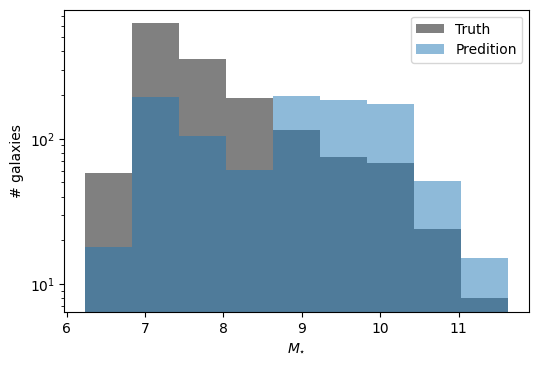

In [57]:
bins = np.linspace(np.min(df['M_g']), np.max(df['M_g']), 10)

plt.figure(dpi = 100)
plt.hist(df['M_g'], bins = bins, color = 'gray', label = 'Truth')
plt.hist(df_sm['M_g'], bins = bins, color = 'C0', alpha = 0.5, label = 'Predition')
plt.xlabel(r'$M_{\star}$')
plt.ylabel(r'# galaxies')
plt.legend()
plt.yscale('log')

### 3.2. Choosing a specific region to reduce/augment

We can let specify the relative region of interest of the prediction $y$ using: $[y_{\mathrm{value}}, 0/1]$, where:
* `0`: minority
* `1`: majority
Then, the code will increase the minority values and decrease the samples in the majority region of the distribution.

In [58]:
rg_mtrx = [
    [7.0, 1],  ## over-sample ("minority")
    [9.0, 0]  ## under-sample ("majority")
]

In [59]:
df_sm = smogn.smoter(data = df_train, y = "M_g", rel_ctrl_pts_rg = rg_mtrx)

r_index: 100%|##########| 187/187 [00:00<00:00, 620.69it/s]


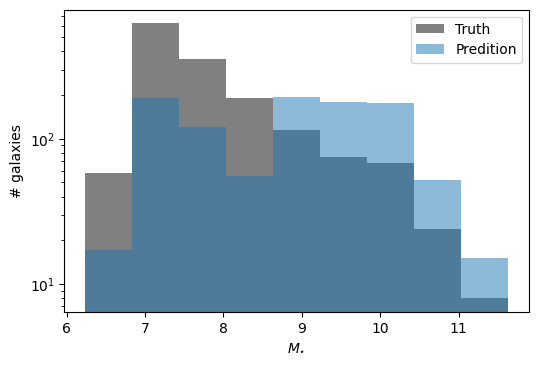

In [60]:
bins = np.linspace(np.min(df['M_g']), np.max(df['M_g']), 10)

plt.figure(dpi = 100)
plt.hist(df['M_g'], bins = bins, color = 'gray', label = 'Truth')
plt.hist(df_sm['M_g'], bins = bins, color = 'C0', alpha = 0.5, label = 'Predition')
plt.xlabel(r'$M_{\star}$')
plt.ylabel(r'# galaxies')
plt.legend()
plt.yscale('log')

### 3.3. YOUR TURN

Do the same SMOGN exercise in the case of galaxies:
* color
* SFR

Try to play around different regions of interest and take a look at the resulted distributions.
Remember, there is no final answer here, the best distribution is the one which gives to you the
best predictions of the interested property.

## 4. Training the NN with the augmented dataset

Now we are going to train the model with the augmented dataset. Let's apply `optuna` here!

### 4.0. Dealing with the data

In [61]:
#Defining the data
x_train = np.array([df_sm['M_h'], df_sm['R_h'], df_sm['V_h']]).T
x_test = np.array([df_test['M_h'], df_test['R_h'], df_test['V_h']]).T

y_train = np.array([df_sm['M_g']]).T
y_test = np.array([df_test['M_g']]).T

In [62]:
#Preparing data
mean_data = np.mean(x_train, axis = 0)
std_data = np.std(x_train, axis = 0)
mean_data, std_data

(array([11.22632109, -6.52381319,  2.12770745]),
 array([0.69509116, 0.23168389, 0.24215229]))

In [63]:
x_train -= mean_data
x_train /= std_data
x_test -= mean_data
x_test /= std_data

The objective function

In [64]:
def objective(trial):
    
    #Defining the hyperparameters and their ranges
    n_layers = trial.suggest_int('n_layers', 0, 5)
    hiddens = trial.suggest_int('hiddens', 0, 64)
    
    #The model
    def base_model():
        model = models.Sequential() 
        model.add(layers.Dense(hiddens, activation = 'relu', input_shape = (x_train.shape[1],)))
        for i in range(n_layers):
            model.add(layers.Dense(hiddens, activation = 'relu'))
        model.add(layers.Dense(1))
        
        model.compile(optimizer = 'Adam', loss = 'mse')
    
        return model
    
    my_model = KerasRegressor(build_fn = base_model)
    
    #Fitting the model
    no_epochs = 20
    batch_size = 20
    validation_split = 0.2
    history = my_model.fit(x_train, y_train, epochs = no_epochs, batch_size = batch_size, 
                 validation_split = validation_split, verbose = False)

    #Validation criteria to optmize
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    validation = 10000.
    
    for i in range(no_epochs):
        if val_loss[i] < train_loss[i]:
            validation = val_loss[i]
            
            my_model.model.save(f'SMOGN-trial{trial.number}-optuna_model.h5')
        
    return validation

The evaluation

In [65]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 3)

[I 2023-01-19 17:37:45,554] A new study created in memory with name: no-name-e682122a-8e33-4b9b-8811-03037d9e5eab
[I 2023-01-19 17:37:47,978] Trial 0 finished with value: 0.19713781774044037 and parameters: {'n_layers': 1, 'hiddens': 30}. Best is trial 0 with value: 0.19713781774044037.
[I 2023-01-19 17:37:50,642] Trial 1 finished with value: 0.16312801837921143 and parameters: {'n_layers': 2, 'hiddens': 48}. Best is trial 1 with value: 0.16312801837921143.
[I 2023-01-19 17:37:53,376] Trial 2 finished with value: 0.2331216186285019 and parameters: {'n_layers': 4, 'hiddens': 45}. Best is trial 1 with value: 0.16312801837921143.


The best model

In [66]:
best_trial = study.best_trial
print("Best trial: ", best_trial.number)
print("Best hyperparameters: {}".format(best_trial.params))

Best trial:  1
Best hyperparameters: {'n_layers': 2, 'hiddens': 48}


Loading the model

In [67]:
#Loading the model
loaded_model = load_model(f'SMOGN-trial{best_trial.number}-optuna_model.h5')

In [68]:
#Predictions
prediction_3 = loaded_model.predict(x_test)

10/10 [==============================] - 0s 1ms/step


Scores

In [69]:
#Scores
MSE_3 = mean_squared_error(prediction_3, y_test)
MSE_3

0.08208176881025459

Visualizing

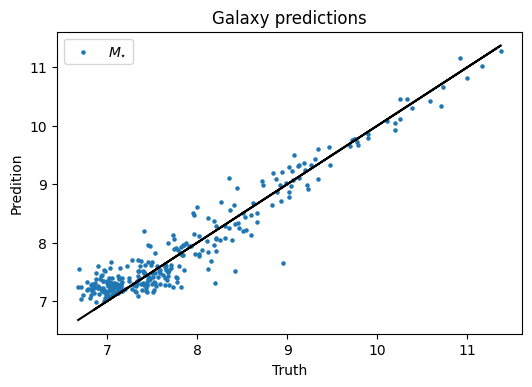

In [70]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')
plt.scatter(y_test, prediction_3, s = 5, color = 'C0', label = '$M_{\star}$')
plt.xlabel(r'Truth')
plt.plot(y_test, y_test, color = 'black')
plt.ylabel(r'Predition')
plt.legend()

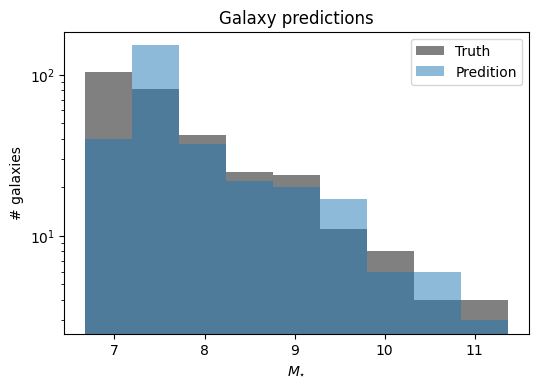

In [71]:
plt.figure(dpi = 100)
plt.title('Galaxy predictions')

bins = np.linspace(np.min(y_test), np.max(y_test), 10)
plt.hist(y_test, bins = bins, color = 'gray', label = 'Truth')
plt.hist(prediction_3, bins = bins, color = 'C0', alpha = 0.5, label = 'Predition')
plt.xlabel(r'$M_{\star}$')
plt.ylabel(r'# galaxies')
plt.legend()
plt.yscale('log')

## 5. Final comparison

Now we summarize all the different results:

### 5.1. Scores

In [73]:
print('Simple NN: MSE = ', MSE_1)
print('Optuna NN: MSE = ', MSE_2)
print('SMOGN optuna NN: MSE = ', MSE_3)

Simple NN: MSE =  0.1038246163867994
Optuna NN: MSE =  0.08365326283927596
SMOGN optuna NN: MSE =  0.08208176881025459


### 5.2. Scatter plots

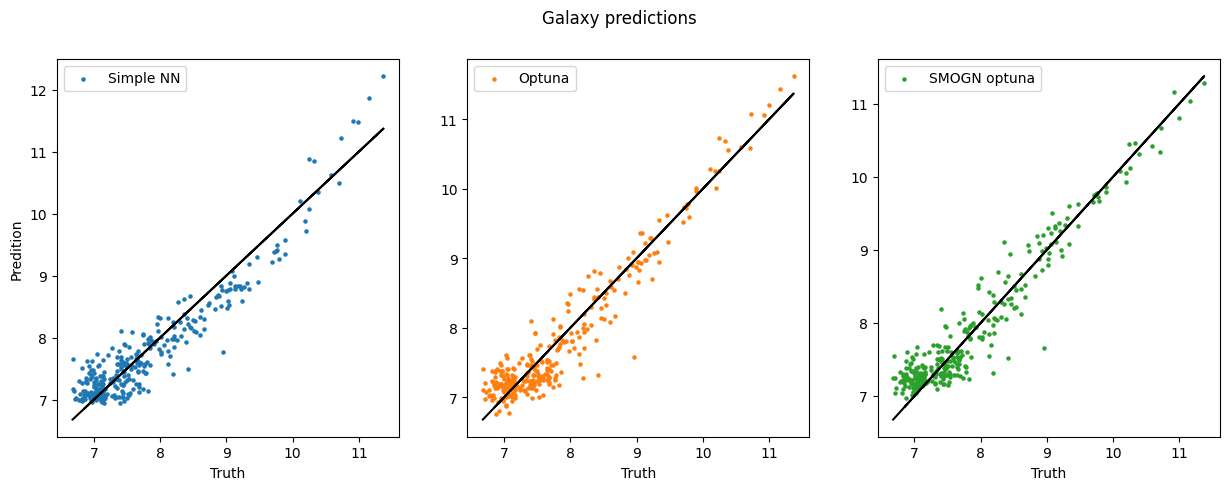

In [75]:
fig = plt.figure(dpi = 100, figsize = (15, 5))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots()

fig.suptitle('Galaxy predictions')

axs[0].scatter(y_test, prediction_1, s = 5, color = 'C0', label = 'Simple NN')
axs[0].set_xlabel(r'Truth')
axs[0].plot(y_test, y_test, color = 'black')
axs[0].set_ylabel(r'Predition')
axs[0].legend()

axs[1].scatter(y_test, prediction_2, s = 5, color = 'C1', label = 'Optuna')
axs[1].set_xlabel(r'Truth')
axs[1].plot(y_test, y_test, color = 'black')
axs[1].legend()

axs[2].scatter(y_test, prediction_3, s = 5, color = 'C2', label = 'SMOGN optuna')
axs[2].plot(y_test, y_test, color = 'black')
axs[2].set_xlabel(r'Truth')
axs[2].legend()

### 5.3. Distribution plots

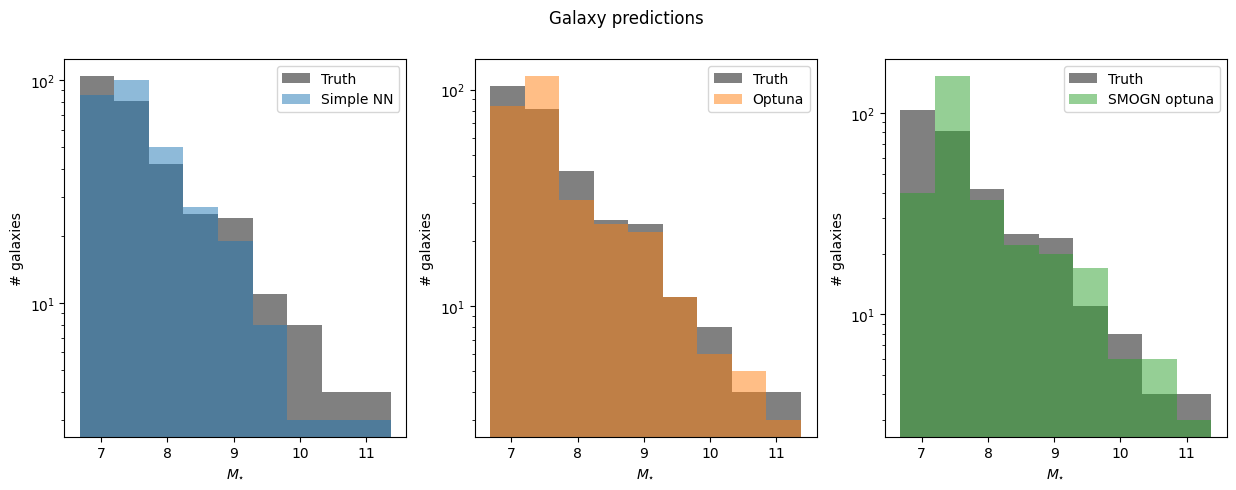

In [77]:
fig = plt.figure(dpi = 100, figsize = (15, 5))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots()

fig.suptitle('Galaxy predictions')

bins = np.linspace(np.min(y_test), np.max(y_test), 10)

axs[0].hist(y_test, bins = bins, color = 'gray', label = 'Truth')
axs[0].hist(prediction_1, bins = bins, color = 'C0', alpha = 0.5, label = 'Simple NN')
axs[0].set_xlabel(r'$M_{\star}$')
axs[0].set_ylabel(r'# galaxies')
axs[0].legend()
axs[0].set_yscale('log')

axs[1].hist(y_test, bins = bins, color = 'gray', label = 'Truth')
axs[1].hist(prediction_2, bins = bins, color = 'C1', alpha = 0.5, label = 'Optuna')
axs[1].set_xlabel(r'$M_{\star}$')
axs[1].set_ylabel(r'# galaxies')
axs[1].legend()
axs[1].set_yscale('log')

axs[2].hist(y_test, bins = bins, color = 'gray', label = 'Truth')
axs[2].hist(prediction_3, bins = bins, color = 'C2', alpha = 0.5, label = 'SMOGN optuna')
axs[2].set_xlabel(r'$M_{\star}$')
axs[2].set_ylabel(r'# galaxies')
axs[2].legend()
axs[2].set_yscale('log')